In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

Using GPU!
Using GPU!
Using GPU!
No TPUs...


In [2]:
!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [3]:
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

In [4]:
u,v=lapOp.diagonalize()

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_utils/tensor.py:16: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  R = torch.cholesky(VTV, upper=True)  # (*BMV, nguess, nguess)
/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_impls/linalg/symeig.py:174: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion

# Spectrum with no training 

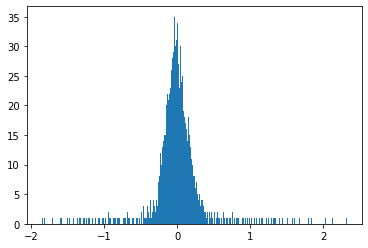

In [5]:
u = u.to('cpu')
plt.hist(u.numpy(),bins=300)
plt.show()

# Training the model 

In [6]:

optimizer = torch.optim.SGD
pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5)

Epoch 1
-------------------------------
Epoch training loss: 0.901131 	Epoch training accuracy: 74.55%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.50%,                 Avg loss: 0.412757 



(0.4127569341460864, 88.5)

# Spectrum after training 

In [7]:
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)
uTrained,vTrained = lapOp.diagonalize()

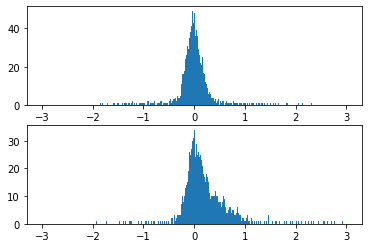

In [8]:
uTrained = uTrained.to('cpu')
plt.figure(1)
plt.subplot(211)
plt.hist(u.numpy(),bins=300,range=(-3,3))
plt.subplot(212)
plt.hist(uTrained.numpy(),bins=300,range=(-3,3))
plt.show()

# Spectrum evolution

Epoch 1
-------------------------------
Epoch training loss: 0.964565 	Epoch training accuracy: 72.54%                                                               
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.27%,                 Avg loss: 0.407202 

Epoch 1
-------------------------------
Epoch training loss: 0.349636 	Epoch training accuracy: 89.78%                                      500 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.36%,                 Avg loss: 0.299601 

Epoch 1
-------------------------------
Epoch training loss: 0.281609 	Epoch training accuracy: 91.83%                                                                
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.70%,                 Avg loss: 0.248616 



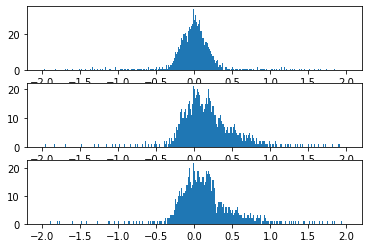

In [9]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 2


plt.figure(1)
epochs=epochs+1
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights)
    u,v = lapOp.diagonalize()
    plt.subplot(100*epochs + 11+i)
    plt.hist(u.to('cpu').numpy(),bins=300,range=(-2,2))
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(-0.0078, device='cuda:0')


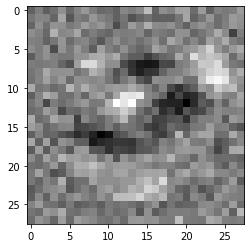

In [10]:
#Plotting eigenvectors 
idx = 6

img =-v.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')


print(u[285])

# With absolute value : 

Epoch 1
-------------------------------
Epoch training loss: 0.940808 	Epoch training accuracy: 72.74%                                      0 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.56%,                 Avg loss: 0.394223 

Epoch 1
-------------------------------
Epoch training loss: 0.348004 	Epoch training accuracy: 89.91%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.32%,                 Avg loss: 0.302348 



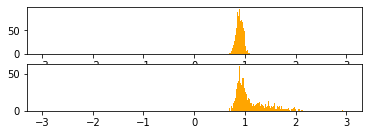

In [11]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='abs')
    uabs,vabs = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(uabs.to('cpu').numpy(),bins=300,range=(-3,3),color='orange')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(24.6742, device='cuda:0')


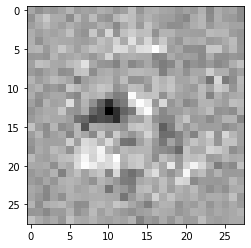

In [12]:
#Plotting eigenvectors 
idx = -8
print(uabs[idx])

img = vabs.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')



# With ReLU

Epoch 1
-------------------------------
Epoch training loss: 0.936106 	Epoch training accuracy: 73.65%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.22%,                 Avg loss: 0.416524 

Epoch 1
-------------------------------
Epoch training loss: 0.346853 	Epoch training accuracy: 90.02%                                      500 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.30%,                 Avg loss: 0.297879 



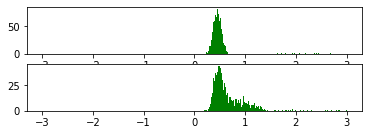

In [13]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    urelu,vrelu = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(urelu.to('cpu').numpy(),bins=300,range=(-3,3),color='green')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(1.8094, device='cuda:0')
torch.Size([894, 893])
tensor([-0.0033,  0.0428,  0.0209,  0.0426,  0.0167,  0.0122, -0.0249,  0.0258,
         0.0631,  0.0369], device='cuda:0')


tensor(8, device='cuda:0')

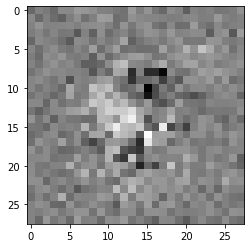

In [14]:
#Plotting eigenvectors 
idx = 789
print(urelu[idx])

img = vrelu.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

print(vrelu.shape)
print(-vrelu.T[idx][-10:])
(-vrelu.T[idx][-10:]).argmax()

In [15]:
torch.argmax(torch.abs(vrelu.T[-5][:10]))

tensor(6, device='cuda:0')

# High spectrum tests

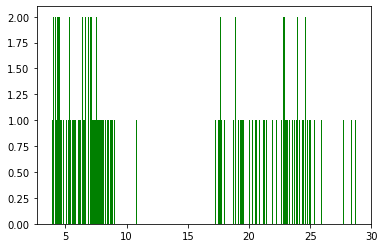

In [16]:
plt.hist(uabs.to('cpu')[28*28:].numpy(),bins=300,color='green')
plt.show()

In [17]:
import time 
#Plotting eigenvectors 
idx = 888
print(uabs[idx])


def saveEigenImages():
    i=28*28
    while i <893:
        idx = i 
        if vabs.T[idx][:28*28].mean()<(vabs.T[idx][:28*28].max()+vabs.T[idx][:28*28].min())/2:
            vabs.T[idx]=-vabs.T[idx]
        img = vabs.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayer' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 


tensor(25.3425, device='cuda:0')


In [18]:
!ls

basic_tutorial_gridsearch_benchmarking.ipynb  Ensemble_learning.ipynb
basic_tutorial_image.ipynb		      Intersection_Homology.ipynb
basic_tutorial_QandA.ipynb		      lapInputLayer
basic_tutorial_regression.ipynb		      lapInputLayerBin
basic_tutorial_tabular.ipynb		      lapInputLayer.zip
basic_tutorial_textClass.ipynb		      LaplacianSpectralAnalysis.ipynb
basic_tutorial_translation.ipynb	      optimising_topology.ipynb
compactification.ipynb			      orbit_5k_train.ipynb
data					      runs
decision_boundary_tori.ipynb		      TopactivationFC_tutorial.ipynb


# Binary mode

In [19]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from gdeep.data import DataLoaderFromArray
from torch.utils.data import DataLoader, random_split


writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")

dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


dataset = datasets.MNIST(root='./data',transform=ToTensor())
idx  = torch.logical_or(dataset.targets==4,dataset.targets==6)
dataset.targets = ((dataset.targets[idx]-4)/2).int()
dataset.data = dataset.data[idx]


my_dl = DataLoader(dataset)


train_len = int(len(dataset)*5/6)
train_set, test_set = random_split(dataset, [train_len, int(len(dataset)) - train_len])

dl_tr2 = DataLoader(train_set, batch_size=32, shuffle=True) # Train dataloader
dl_ts2 = DataLoader(test_set, batch_size=32, shuffle=False) # Test set 


""" Crappy stuff 
j = int(len(data)*5/6) 
print(data.type())


dl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])
dl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)



#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]
    
#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]

print(len(dl_tr),len(dl_ts))
print(len(dl_tr2),len(dl_ts2))
"""

' Crappy stuff \nj = int(len(data)*5/6) \nprint(data.type())\n\n\ndl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])\ndl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)\n\n\n\n#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]\n    \n#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]\n\nprint(len(dl_tr),len(dl_ts))\nprint(len(dl_tr2),len(dl_ts2))\n'

In [20]:
for x in dl_ts2.dataset:
    print(x[0].type())
    break 

torch.FloatTensor


Epoch 1
-------------------------------
Epoch training loss: 0.561891 	Epoch training accuracy: 88.95%                                       ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.42%,                 Avg loss: 0.144713 

Epoch 1
-------------------------------
Epoch training loss: 0.062705 	Epoch training accuracy: 98.64%                                      5 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.78%,                 Avg loss: 0.046441 

Epoch 1
-------------------------------
Epoch training loss: 0.037686 	Epoch training accuracy: 98.84%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.57%,                 Avg loss: 0.040967 

Epoch 1
-------------------------------
Epoch training loss: 0.032398 	Epoch t

Validation results: 
 Accuracy: 99.85%,                 Avg loss: 0.009595 

Epoch 1
-------------------------------
Epoch training loss: 0.008626 	Epoch training accuracy: 99.83%                                      5 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.95%,                 Avg loss: 0.003530 

Epoch 1
-------------------------------
Epoch training loss: 0.007348 	Epoch training accuracy: 99.80%                                      245 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.95%,                 Avg loss: 0.005634 

Epoch 1
-------------------------------
Epoch training loss: 0.005756 	Epoch training accuracy: 99.91%                                      45 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.80%,                 Avg loss: 0.007356

Epoch training loss: 0.001269 	Epoch training accuracy: 99.99%                                      245 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.001070 

Epoch 1
-------------------------------
Epoch training loss: 0.001216 	Epoch training accuracy: 99.99%                                      245 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000747 

Epoch 1
-------------------------------
Epoch training loss: 0.001062 	Epoch training accuracy: 99.99%                                      245 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.001038 

Epoch 1
-------------------------------
Epoch training loss: 0.001028 	Epoch training accuracy: 100.00%       

Epoch training loss: 0.000313 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000404 

Epoch 1
-------------------------------
Epoch training loss: 0.000334 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000256 

Epoch 1
-------------------------------
Epoch training loss: 0.000320 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000295 

Epoch 1
-------------------------------
Epoch training loss: 0.000302 	Epoch training accuracy: 100.00%                                        

Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000154 

Epoch 1
-------------------------------
Epoch training loss: 0.000179 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000148 

Epoch 1
-------------------------------
Epoch training loss: 0.000168 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000172 

Epoch 1
-------------------------------
Epoch training loss: 0.000153 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000225 

Epoch 1
-----------------

Epoch training loss: 0.000107 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000133 

Epoch 1
-------------------------------
Epoch training loss: 0.000119 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000085 

Epoch 1
-------------------------------
Epoch training loss: 0.000102 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000142 

Epoch 1
-------------------------------
Epoch training loss: 0.000116 	Epoch training accuracy: 100.00%                                        

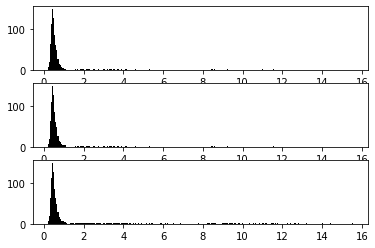

In [21]:


arch = [28*28, 50, 50, 50, 2]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr2, dl_ts2), loss_fn, writer)


epochs = 3
overfit = True


if overfit:
    for epoch in range(150):
         pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)

plt.figure(1)
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    ubin,vbin = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(ubin.to('cpu').numpy(),bins=300,color='black')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

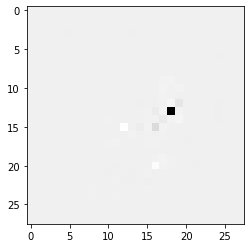

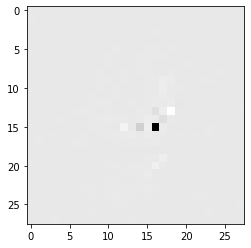

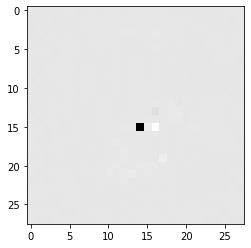

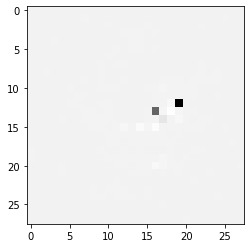

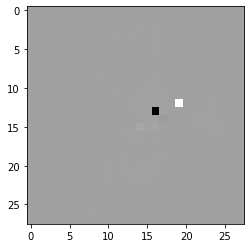

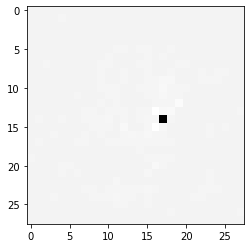

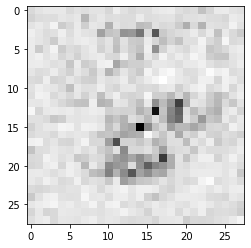

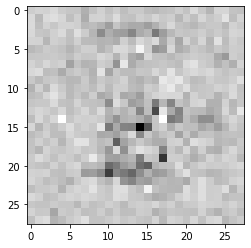

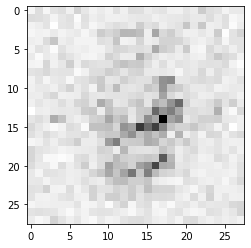

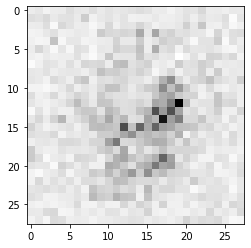

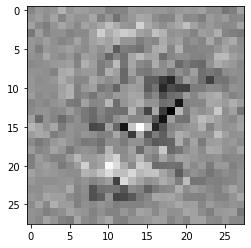

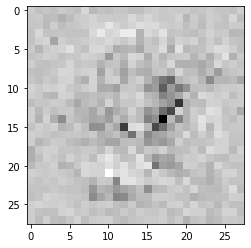

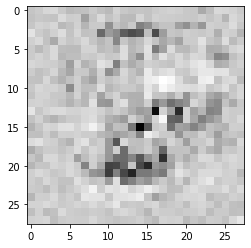

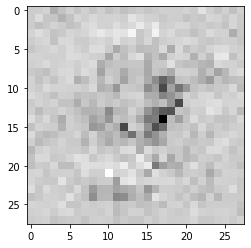

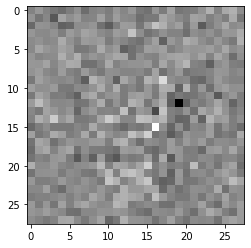

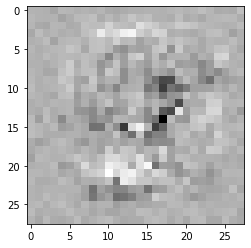

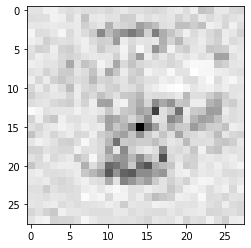

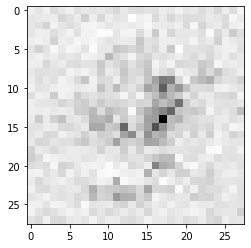

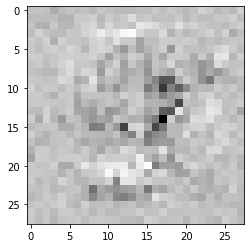

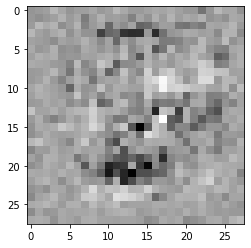

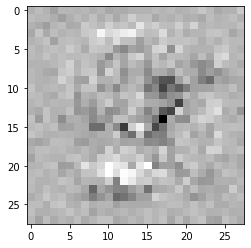

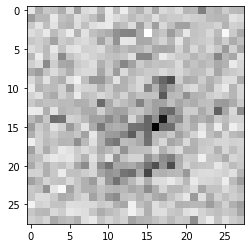

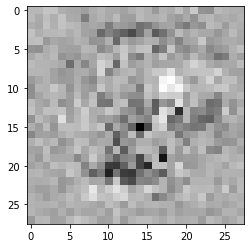

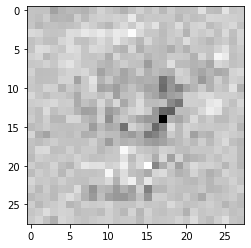

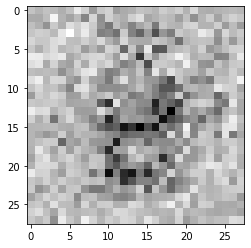

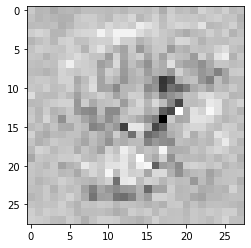

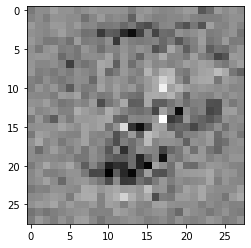

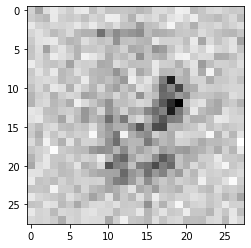

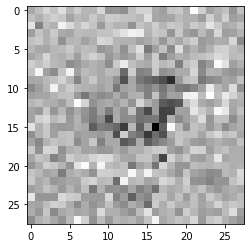

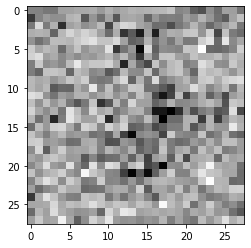

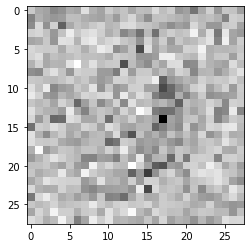

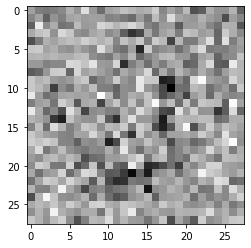

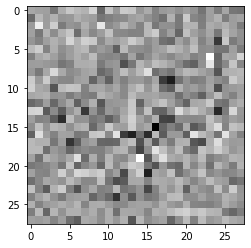

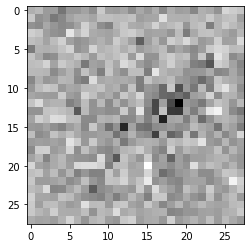

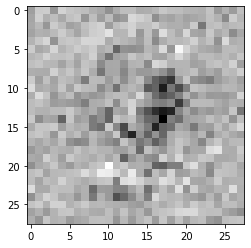

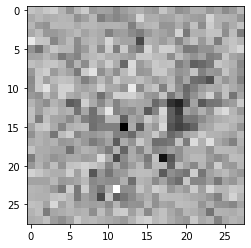

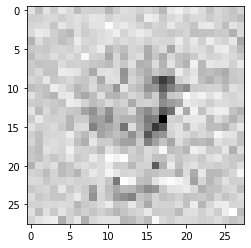

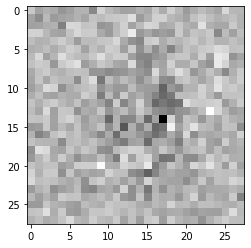

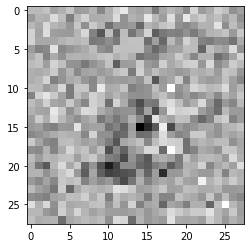

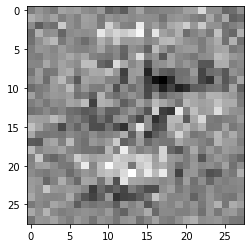

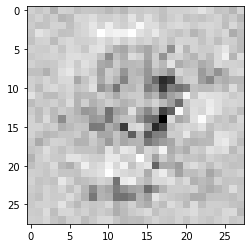

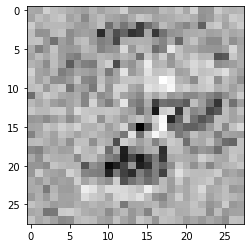

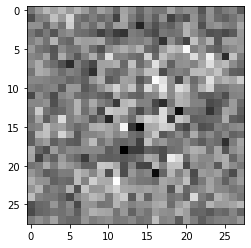

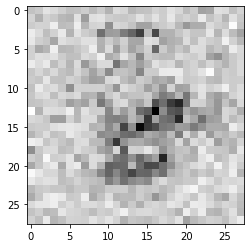

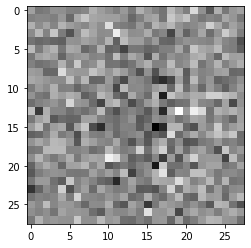

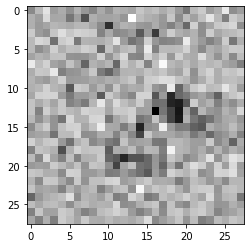

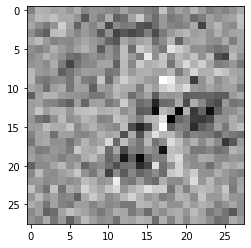

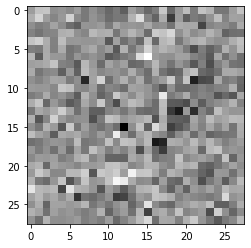

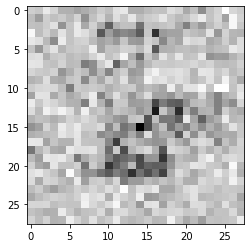

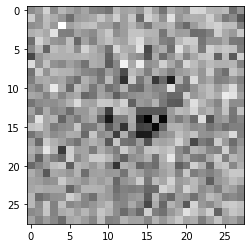

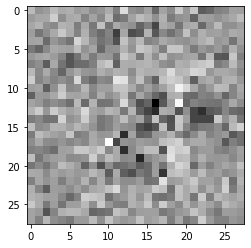

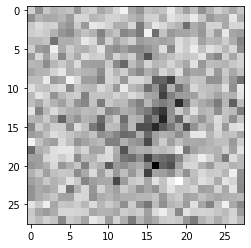

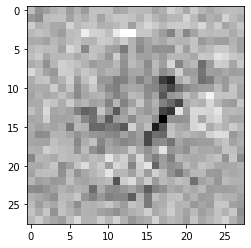

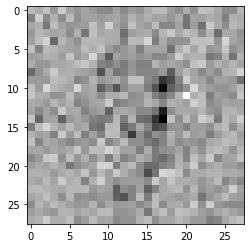

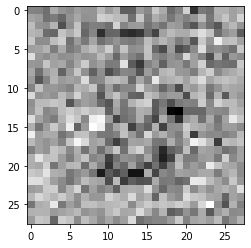

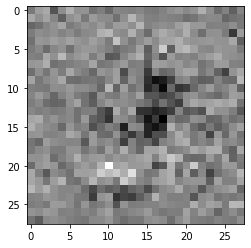

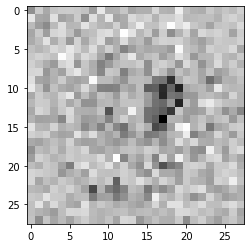

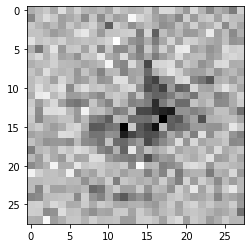

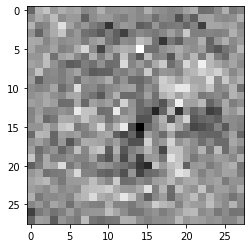

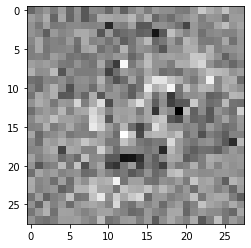

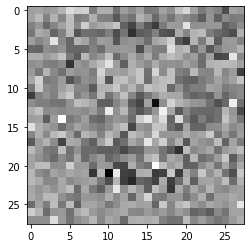

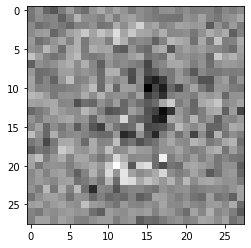

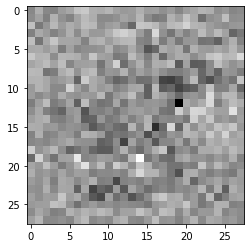

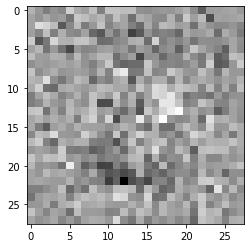

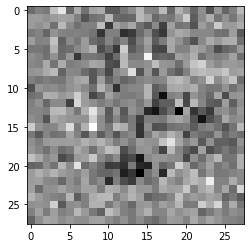

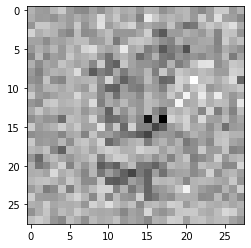

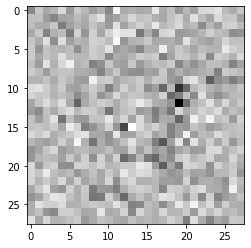

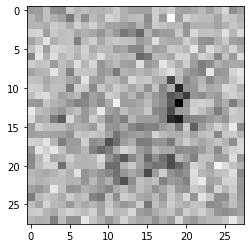

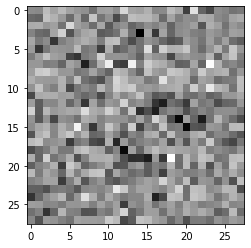

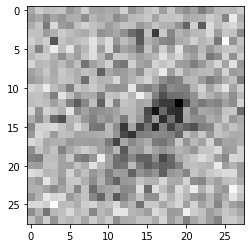

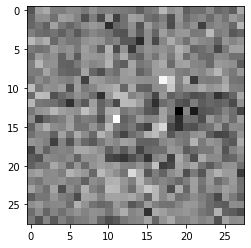

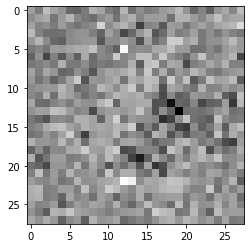

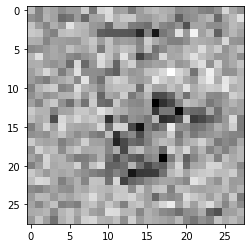

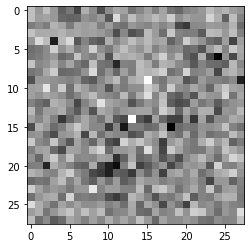

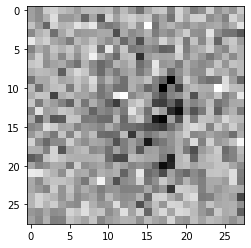

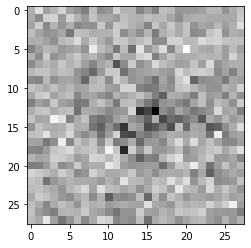

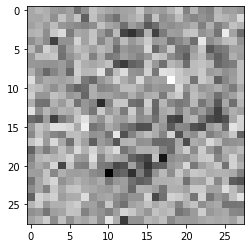

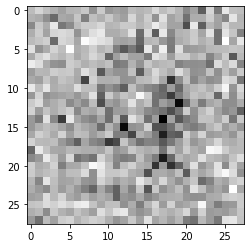

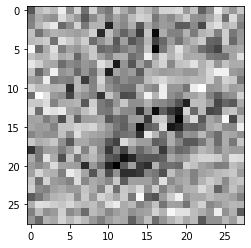

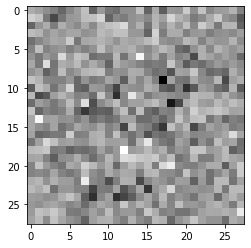

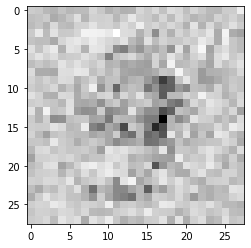

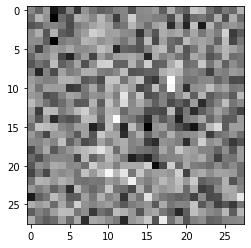

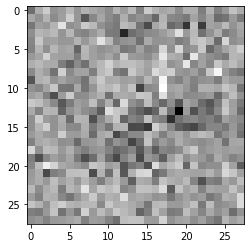

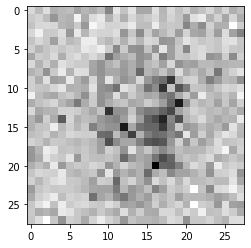

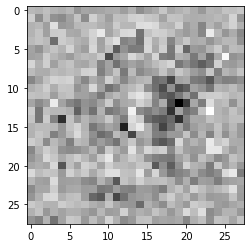

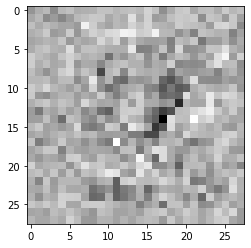

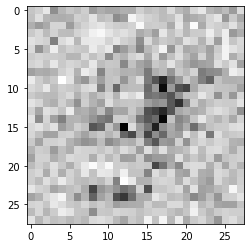

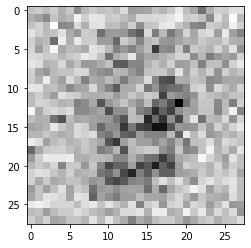

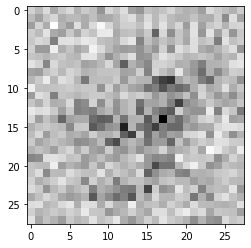

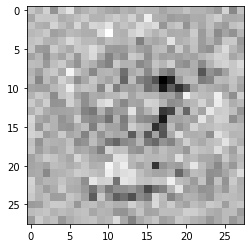

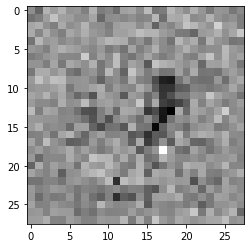

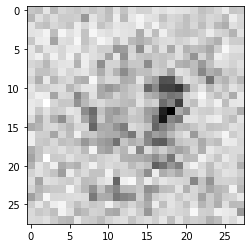

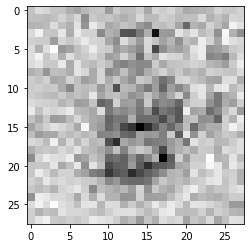

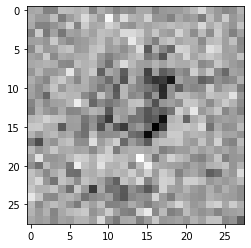

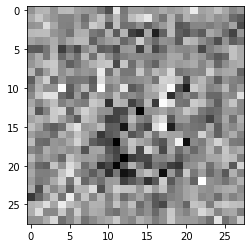

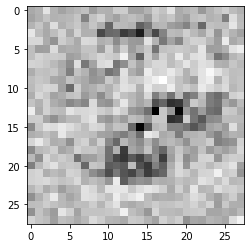

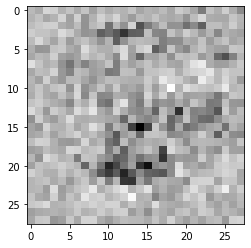

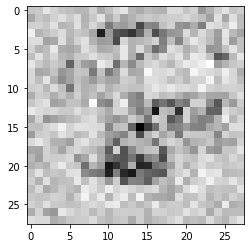

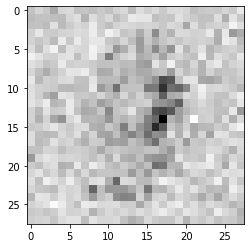

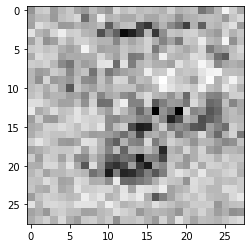

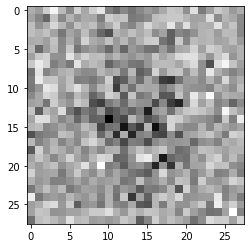

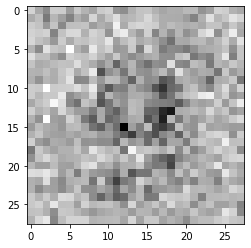

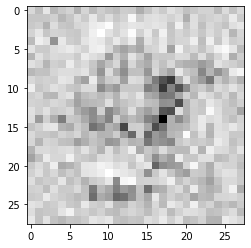

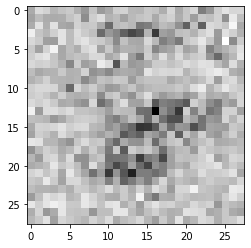

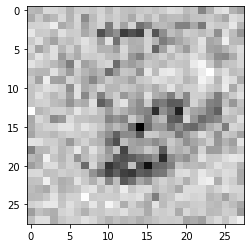

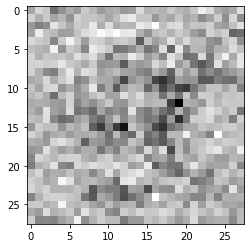

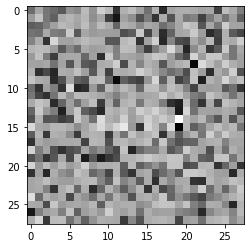

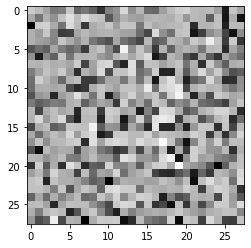

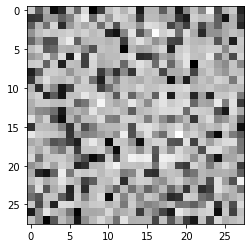

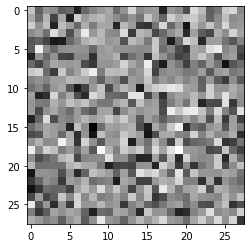

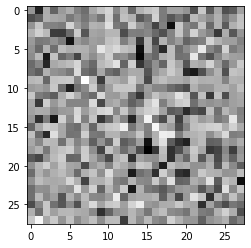

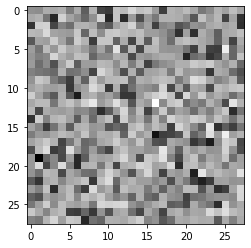

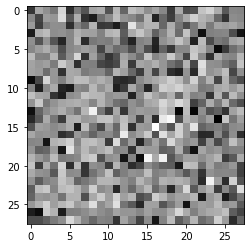

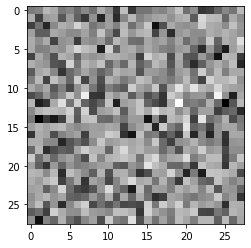

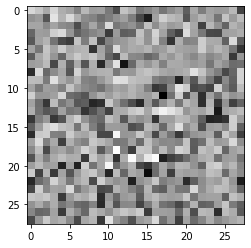

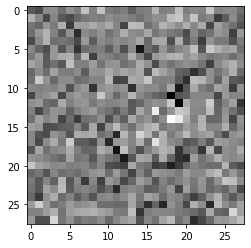

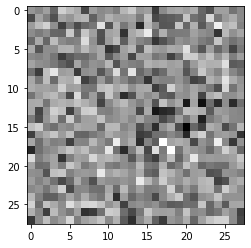

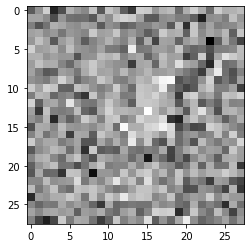

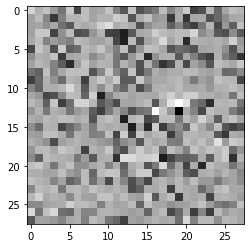

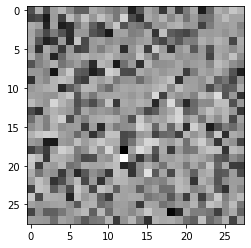

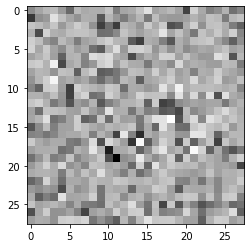

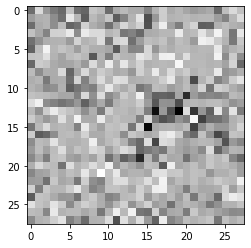

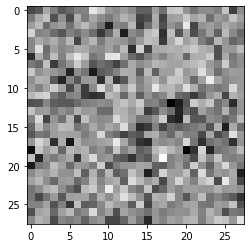

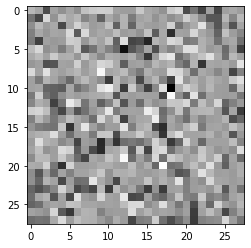

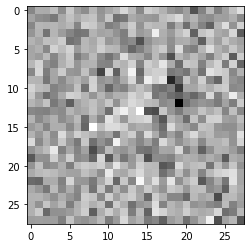

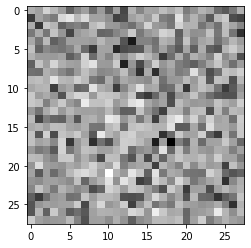

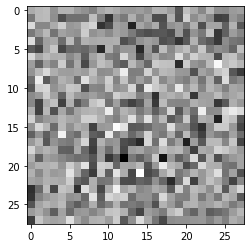

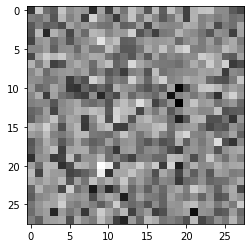

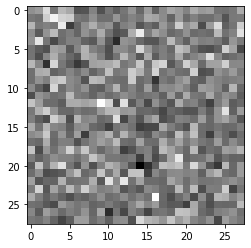

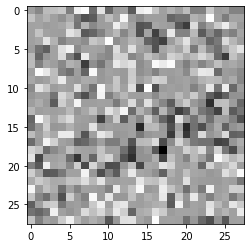

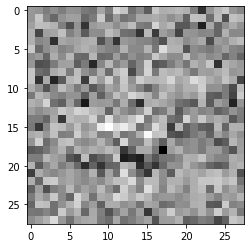

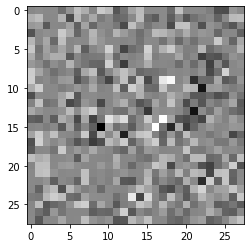

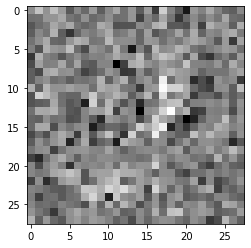

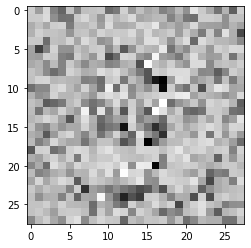

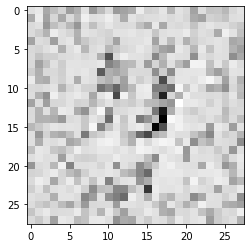

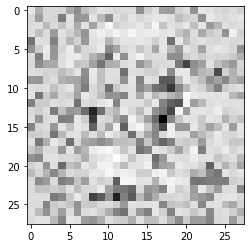

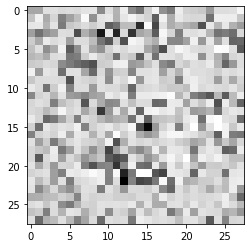

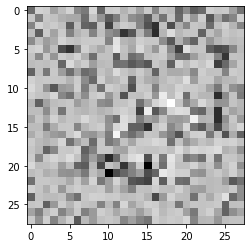

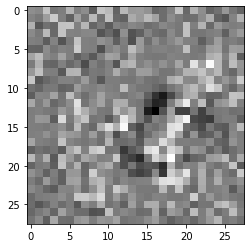

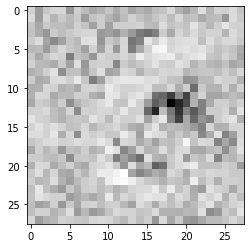

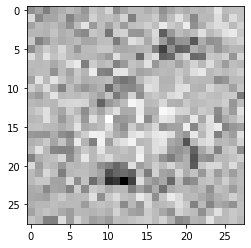

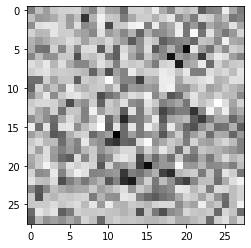

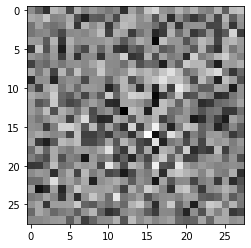

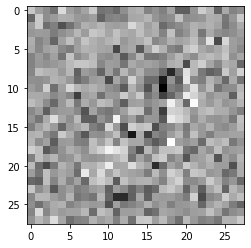

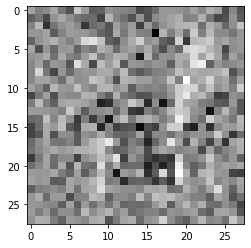

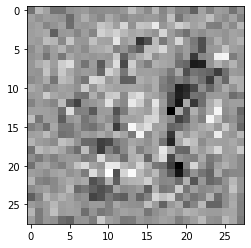

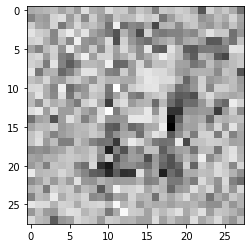

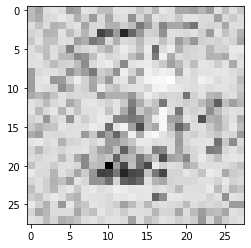

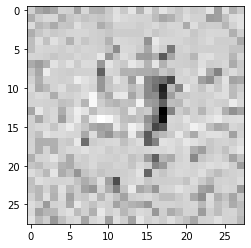

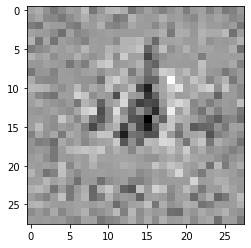

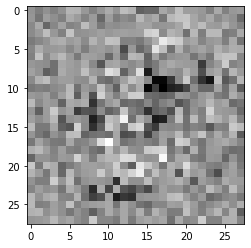

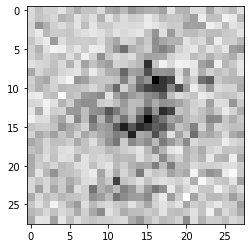

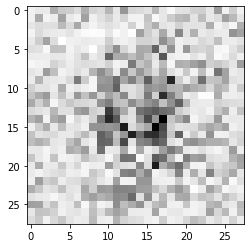

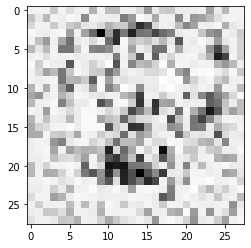

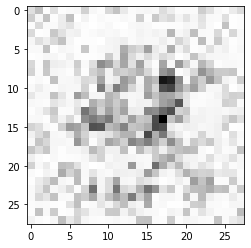

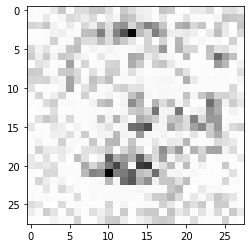

In [22]:
def saveEigenImages2():
    i=28*28-5
    while i <len(vbin.T):
        idx = i 
        if vbin.T[idx][:28*28].mean()<(vbin.T[idx][:28*28].max()+vbin.T[idx][:28*28].min())/2:
            vbin.T[idx]=-vbin.T[idx]
        img = vbin.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayerBin' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 

saveEigenImages2()

tensor(2.2732, device='cuda:0')
tensor([-0.0112,  0.2275,  0.0036,  0.0684,  0.0033, -0.1053,  0.3878, -0.0220,
        -0.0450, -0.0178], device='cuda:0')


tensor(6, device='cuda:0')

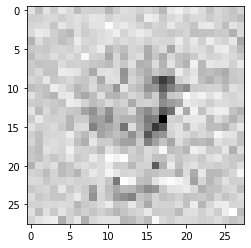

In [23]:
#Plotting eigenvectors 
idx = 815
print(ubin[idx])
img = vbin.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
print(-vbin.T[idx][-10:])
(-vbin.T[idx][-10:]).argmax()



In [24]:
vbin.T[28*28+25][872]


tensor(0.0387, device='cuda:0')

# Getting to know the eigenvectors : metrics 

- sign 
- Total entropy 
- Argmax 
- value at argmax 
- spatial correlations on input 

In [25]:
def positivise(v):
    """Transforme le signe de chaque colonne de la matrice v de sorte à ce que l'argmax soit de signe positif """
    res = torch.zeros(v.shape)
    for idx in range(len(v.T)):
        res[:,idx]=torch.sign(v.T[idx][torch.abs(v.T[idx]).argmax()])*v.T[idx]
    return res 
        
def sign(vec):
    """Détermine la fraction de signes - pour un vecteur propre vec"""
    return (torch.relu(-torch.sign(vec)).sum())/len(vec)

def maxValue(vec):
    return vec.max()

def argMax(vec):
    return vec.argmax()

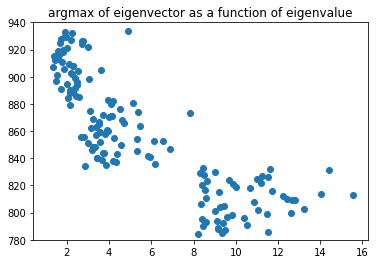

In [27]:
vbin = positivise(vbin)
vbin=vbin.to('cpu')
ubin = ubin.to('cpu')
plt.scatter(ubin[28*28:],[argMax(vec) for vec in vbin.T[28*28:]])
plt.title('argmax of eigenvector as a function of eigenvalue')
plt.ylim(780,940)
plt.show()

Text(0.5, 1.0, 'maximum value of eigenvector as a function of eigenvalue')

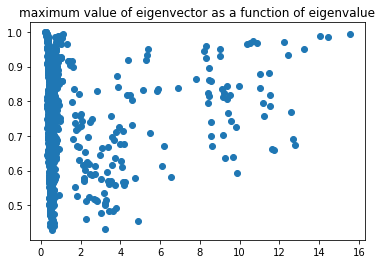

In [28]:
plt.scatter(ubin,[maxValue(vec) for vec in vbin.T])
plt.title('maximum value of eigenvector as a function of eigenvalue')

# Attaques adversariales 

In [163]:
arch = [28*28, 50, 50, 50,50,50,50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 15


for i in range(epochs):
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
    
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights,positivation='relu')
u,v = lapOp.diagonalize()





Epoch 1
-------------------------------
Epoch training loss: 2.302299 	Epoch training accuracy: 14.09%                                                                
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 17.92%,                 Avg loss: 2.301832 

Epoch 1
-------------------------------
Epoch training loss: 2.298149 	Epoch training accuracy: 18.43%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 10.09%,                 Avg loss: 2.279616 

Epoch 1
-------------------------------
Epoch training loss: 1.818371 	Epoch training accuracy: 28.47%                                                                
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 55.72%,                 Avg loss: 1.196419 

Epoch 1
-------------------------------
Epoch training loss: 0.740396 	Ep

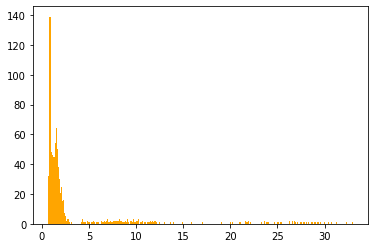

In [67]:
plt.hist(u.to('cpu').numpy(),bins=300,color='orange')
plt.show()


# Tests sur un input 

In [216]:
epsilon = 0.1
topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    indices = torch.randperm(data.shape[1])
    data_noised = (data_perturbed-data)[indices]+data
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    break 
    
# Weird last layers to see 

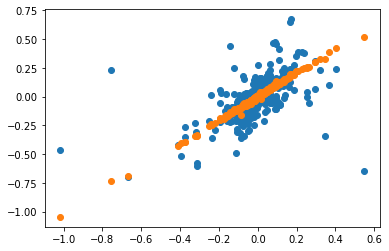

In [218]:
idx = 3
normal_activation = normal_activation.to('cpu')
perturbed_activation = perturbed_activation.to('cpu')
noised_activation =  noised_activation.to('cpu')

v=v.to('cpu')
plt.scatter(v.T@normal_activation[idx]/normal_activation[idx].max(),v.T@perturbed_activation[idx]/perturbed_activation[idx].max())
plt.scatter(v.T@normal_activation[idx]/normal_activation[idx].max(),v.T@noised_activation[idx]/noised_activation[idx].max())

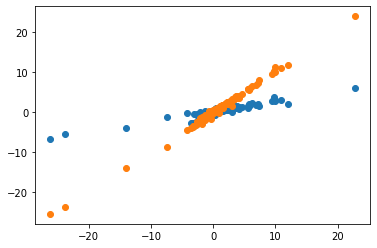

In [226]:
idx = 6
normal_activation = normal_activation.to('cpu')
perturbed_activation = perturbed_activation.to('cpu')
noised_activation =  noised_activation.to('cpu')

v=v.to('cpu')
plt.scatter(normal_activation[idx],perturbed_activation[idx])
plt.scatter(normal_activation[idx],noised_activation[idx])


In [220]:

print((normal_activation[idx]-perturbed_activation[idx]).norm())
print((v.T@(normal_activation[idx]-perturbed_activation[idx])).norm())
print((v.T@(normal_activation[idx]-noised_activation[idx])).norm())

tensor(44.3176)
tensor(44.2448)
tensor(5.3265)


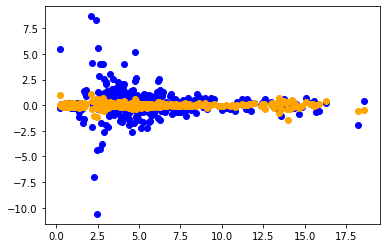

In [236]:
u = u.to('cpu')
idx = 9
plt.scatter(u,v.T@perturbed_activation[idx]-(v.T@normal_activation[idx]),color='blue')
plt.scatter(u,v.T@noised_activation[idx]-(v.T@normal_activation[idx]),color='orange')
plt.show()

In [ ]:
# Explication : L'activation perturbée s'éloigne significativement de l'activation normale

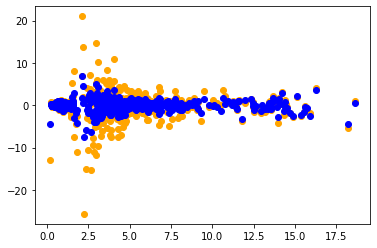

In [240]:
u = u.to('cpu')
idx = 10
plt.scatter(u,v.T@noised_activation[idx],color='orange')
plt.scatter(u,v.T@perturbed_activation[idx],color='blue')

plt.show()

In [232]:
print(normal_activation[idx].norm())
print(noised_activation[idx].norm())
print(perturbed_activation[idx].norm())

tensor(61.0070)
tensor(61.8961)
tensor(20.1103)


In [175]:
print(normal_activation[idx].max())
print(noised_activation[idx].max())
print(perturbed_activation[idx].max())

tensor(22.7749)
tensor(32.2951)
tensor(6.0332)


In [195]:
print(normal_activation[0].shape)

torch.Size([1094])


In [202]:
normal_activation.std()

tensor(1.5612)

# Agrégé sur l'ensemble des inputs 

In [260]:
diffPerturbedNormal = torch.zeros(len(u)).to(DEVICE)
diffNoisedNormal = torch.zeros(len(u)).to(DEVICE)
diffPerturbedNormal2 = torch.zeros(len(u)).to(DEVICE) #Mean of square differences
diffNoisedNormal2 = torch.zeros(len(u)).to(DEVICE) 
maxPerturbed = torch.zeros(len(u)).to(DEVICE) 
maxNoised  = torch.zeros(len(u)).to(DEVICE) 
minPerturbed = 100000*torch.ones(len(u)).to(DEVICE) 
minNoised  = 100000*torch.ones(len(u)).to(DEVICE) 
avgPerturbed = torch.zeros(len(u)).to(DEVICE) 
avgNoised = torch.zeros(len(u)).to(DEVICE) 
avgNormal = torch.zeros(len(u)).to(DEVICE)

nSamples = 0

v=v.to(DEVICE)

for data, target in dl_tr: 
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1).to(DEVICE) #Bernoulli noise 
    # shuffle version 
    indices = torch.randperm(data.shape[1])
    data_noised = (data_perturbed-data)[indices]+data
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    nSamples+=normal_activation.shape[0]
    diffPerturbedNormal += (torch.abs(v.T@(perturbed_activation.T-normal_activation.T))).sum(dim=1)
    diffNoisedNormal += (torch.abs(v.T@(noised_activation.T-normal_activation.T))).sum(dim=1)
    
    avgPerturbed +=torch.abs(v.T@(perturbed_activation.T)).sum(dim=1)
    avgNoised += torch.abs(v.T@(noised_activation.T)).sum(dim=1)
    avgNormal +=torch.abs(v.T@(normal_activation.T)).sum(dim=1)
    
    
    
    maxActuel = torch.max(torch.abs(v.T@(perturbed_activation.T-normal_activation.T)),dim=1).values
    minActuel = torch.min(torch.abs(v.T@(perturbed_activation.T-normal_activation.T)),dim=1).values
    
    

    maxPerturbed = torch.maximum(maxPerturbed,maxActuel)
    minPerturbed = torch.minimum(minPerturbed,minActuel)
    
    
    maxActuel = torch.max(torch.abs(v.T@(noised_activation.T-normal_activation.T)),dim=1).values
    minActuel = torch.min(torch.abs(v.T@(noised_activation.T-normal_activation.T)),dim=1).values
    
    
    maxNoised = torch.maximum(maxNoised,maxActuel)
    minNoised = torch.minimum(minNoised,minActuel)
    
    diffPerturbedNormal2 += ((v.T@(perturbed_activation.T-normal_activation.T))**2).sum(dim=1)
    diffNoisedNormal2 += ((v.T@(noised_activation.T-normal_activation.T))**2).sum(dim=1)
    

diffPerturbedNormal=diffPerturbedNormal/nSamples
diffNoisedNormal=diffNoisedNormal/nSamples
diffPerturbedNormal2=diffPerturbedNormal2/nSamples
diffNoisedNormal2=diffNoisedNormal2/nSamples

avgNoised = avgNoised/nSamples
avgPerturbed = avgPerturbed/nSamples
avgNormal = avgNormal/nSamples

#errPerturbed = torch.sqrt(diffPerturbedNormal2-diffPerturbedNormal**2)
#errNoised = torch.sqrt(diffNoisedNormal2-diffNoisedNormal**2)

errPerturbed = torch.zeros(2,len(u))
errPerturbed[0],errPerturbed[1] = (-minPerturbed+diffPerturbedNormal).to('cpu'),(maxPerturbed-diffPerturbedNormal).to('cpu')
errNoised = torch.zeros(2,len(u))
errNoised[0],errNoised[1] = (-minNoised+diffNoisedNormal).to('cpu'),(maxNoised-diffNoisedNormal).to('cpu')


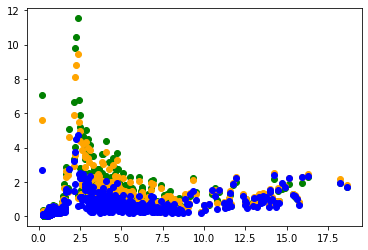

In [261]:
avgPerturbed = avgPerturbed.to('cpu')
avgNoised = avgNoised.to('cpu')
avgNormal = avgNormal.to('cpu')

plt.scatter(u,avgNormal,color='green')
plt.scatter(u,avgNoised,color='orange')
plt.scatter(u,avgPerturbed,color='blue')


plt.show()

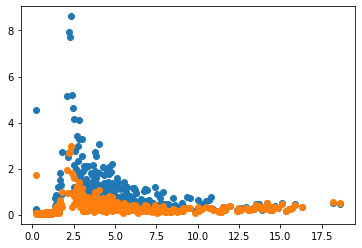

In [243]:
plt.scatter(u,diffPerturbedNormal.to('cpu'))
plt.scatter(u,diffNoisedNormal.to('cpu'))
plt.show()

In [179]:
print((diffNoisedNormal**2).sum(),(diffPerturbedNormal**2).sum())


tensor(95.3155, device='cuda:0') tensor(687.8774, device='cuda:0')


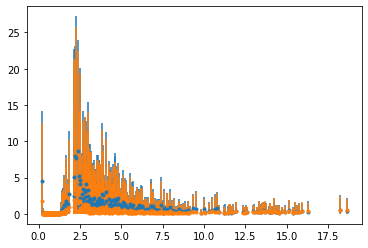

In [180]:
import numpy as np 
plt.errorbar(u,diffPerturbedNormal.to('cpu'),yerr=errPerturbed,marker='.',linestyle='None')
plt.errorbar(u,diffNoisedNormal.to('cpu'),yerr=errNoised,marker='.',linestyle='None')
#plt.xlim(5,15)
plt.show()